                                                                                                  Tecnológico de Costa Rica
                                                                                                  Programa Ciencia de Datos
                                                                                                         Módulo 4: Big Data
                                                                                                      Samuel Monge Alvarado
                                                                                                           7 julio del 2022

# Proyecto Final: 
# Desarrollo de Modelo de Clasificación Binaria en Dataset de Baseball

## Introducción

Este Notebook parte de los archivos generados previamente en la fase de procesamiento del proyecto mediante los ejecutables de main. Los dataframes se leen directamente de la DB de Postgresql en donde fueron escritos.

El set generado cuenta con 450 filas que corresponden a todos los equipos que participaron en el campeonato desde el 2006 hasta el 2021. El set cuenta con 60 columnas o atributos todos numéricos que representan estadísticas de desempeño de distinto tipo por equipo.

El objetivo de desarrollar un modelo de predicción a partir de este dataset es poder determinar si un equipo clasificará a Postemporada según las estadísticas, tanto grupales como individuales que registraron en el año.  

El dataset cuenta con una columna llamada 'Post’ que representa una variable binaria que justamente define si un equipo de Baseball clasificó a Postemporada cuando ‘Post’ == 1, o si ‘Post’ == 0 entonces significa que el equipo no clasificó a la segunda fase.

Se probarán tres modelos de Machine Learning de clasificación (Multilayer Perceptron, Random Forest y Gradient Boosted Trees). Se calcularán sus respectivas métricas de clasificación para compararlos entre sí y definir cuál modelo se adapta mejor a la solución del problema.

También se hará uso de la técnica de Cross Validation para tener mayor representatividad de los datos a la hora de entrenar el modelo. Mediante el contenedor de postgres alojado en Docker se harán algunas asignaciones y lecturas del set hacia la base de datos, tanto del set procesado como del set con sus respectivas predicciones, una vez se hayan aplicado los modelos.

## Configuración de la sesión Spark

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

In [ ]:
# Ajustar el ancho de la celda de código para poder visualizar mejor los datos
from IPython.display import display, HTML

display(HTML("<style>.container { width:110% !important; }</style>"))

In [2]:
from pyspark.sql.types import (StringType, IntegerType, FloatType,DecimalType, StructField, StructType)

spark = SparkSession \
    .builder \
    .appName("Proyecto Samuel") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/07 14:21:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Lectura de los dataframes generados

Se leen los dataframes df_1, df_2 y df_3 generados de los archivos main y que se guardaron en la base de datos Postgresql.

In [3]:
df_1 = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_final1") \
    .load()
df_1.show(5)

22/07/07 14:21:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+------------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+------+----+
|Abb|                  Tm|BatAge| R/G|  PA| bR|  bH|bHR| SB|bBB| bSO|   BA|  OBP|  SLG|GDP|bHBP| SH| SF|IBB|bLOB|PAge|RA/G| ERA| CG|tSho|cSho| SV|    IP|  pH| pR|pHR|pBB| pSO|pHBP| BK| WP| WHIP|pLOB|  E| DP|Attendance|     Payroll|Post|qbH|qbR|qbHR|qbRBI|qbSB|qbBB|qbSO|qbBA|qbOBP|qbSLG|qpW|qpL|qpERA|qpSO|qpH|qpHR|qpBB|qpR|qpWHIP|qpWP|
+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+------------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+--

In [4]:
df_2 = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_final2") \
    .load()
df_2.show(5)

+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+-----------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+------+----+
|Abb|                  Tm|BatAge| R/G|  PA| bR|  bH|bHR| SB|bBB| bSO|   BA|  OBP|  SLG|GDP|bHBP| SH| SF|IBB|bLOB|PAge|RA/G| ERA| CG|tSho|cSho| SV|    IP|  pH| pR|pHR|pBB| pSO|pHBP| BK| WP| WHIP|pLOB|  E| DP|Attendance|    Payroll|Post|qbH|qbR|qbHR|qbRBI|qbSB|qbBB|qbSO|qbBA|qbOBP|qbSLG|qpW|qpL|qpERA|qpSO|qpH|qpHR|qpBB|qpR|qpWHIP|qpWP|
+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+-----------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+-----

In [5]:
df_3 = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_final3") \
    .load()
df_3.show(5)

+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+------------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+------+----+
|Abb|                  Tm|BatAge| R/G|  PA| bR|  bH|bHR| SB|bBB| bSO|   BA|  OBP|  SLG|GDP|bHBP| SH| SF|IBB|bLOB|PAge|RA/G| ERA| CG|tSho|cSho| SV|    IP|  pH| pR|pHR|pBB| pSO|pHBP| BK| WP| WHIP|pLOB|  E| DP|Attendance|     Payroll|Post|qbH|qbR|qbHR|qbRBI|qbSB|qbBB|qbSO|qbBA|qbOBP|qbSLG|qpW|qpL|qpERA|qpSO|qpH|qpHR|qpBB|qpR|qpWHIP|qpWP|
+---+--------------------+------+----+----+---+----+---+---+---+----+-----+-----+-----+---+----+---+---+---+----+----+----+----+---+----+----+---+------+----+---+---+---+----+----+---+---+-----+----+---+---+----------+------------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+--

Unión de los dataframes 1, 2 y 3. Se comprueba que juntos completan las 450 instancias requeridas.

In [6]:
list_df=[df_1,df_2,df_3]
df_original=list_df[0].union(list_df[1]).union(list_df[2])
df_original.count()

450

## Revisión del dataset original

Se cambia el nombre de las columnas R/G y RA/G, con tal de no crear conflictos de asignación.

Se muestra el listado completo de los atributos por abreviatura y tipo de dato. Algunos ejemplos son Edad promedio de los bateadores (BatAge), Promedio de Bateo (BA), Homeruns bateados (bHR), bases robadas (SB), Promedio de Carrera lanzada (ERA), Cantidad de Salvamentos (SV), Strikeouts lanzados (pSO), cantidad de bateadores con 25 o más Homeruns (qbHR), cantidad de lanzadores con 100 o más Strikeouts (qpSO), errores de fildeo incurridos (E), costo total de la planilla (Payroll), etc.

In [7]:
df_original=df_original.withColumnRenamed("R/G","RpG").withColumnRenamed("RA/G","RApG")
df_original.printSchema()

root
 |-- Abb: string (nullable = true)
 |-- Tm: string (nullable = true)
 |-- BatAge: double (nullable = true)
 |-- RpG: double (nullable = true)
 |-- PA: integer (nullable = true)
 |-- bR: integer (nullable = true)
 |-- bH: integer (nullable = true)
 |-- bHR: integer (nullable = true)
 |-- SB: integer (nullable = true)
 |-- bBB: integer (nullable = true)
 |-- bSO: integer (nullable = true)
 |-- BA: double (nullable = true)
 |-- OBP: double (nullable = true)
 |-- SLG: double (nullable = true)
 |-- GDP: integer (nullable = true)
 |-- bHBP: integer (nullable = true)
 |-- SH: integer (nullable = true)
 |-- SF: integer (nullable = true)
 |-- IBB: integer (nullable = true)
 |-- bLOB: integer (nullable = true)
 |-- PAge: double (nullable = true)
 |-- RApG: double (nullable = true)
 |-- ERA: double (nullable = true)
 |-- CG: integer (nullable = true)
 |-- tSho: integer (nullable = true)
 |-- cSho: integer (nullable = true)
 |-- SV: integer (nullable = true)
 |-- IP: double (nullable = true)


### Summary transpuesto

Se imprimen los principales estadísticos de cada uno de los atributos del dataframe original.

In [8]:
def TransposeDF(df, columns, pivotCol):
  columnsValue = list(map(lambda x: str("'") + str(x) + str("',")  + str(x), columns))
  stackCols = ','.join(x for x in columnsValue)
  df_1 = df.selectExpr(pivotCol, "stack(" + str(len(columns)) + "," + stackCols + ")")\
           .select(pivotCol, "col0", "col1")
  final_df = df_1.groupBy(col("col0")).pivot(pivotCol).agg(concat_ws("", collect_list(col("col1"))))\
                 .withColumnRenamed("col0", pivotCol)
  return final_df

In [9]:
from pyspark.sql.functions import *
df_work=df_original.drop("Abb","Tm")
df_summary=df_work.summary()
summary_res=TransposeDF(df_summary, df_work.columns, "summary").sort("summary")
summary_res.show(summary_res.count())

+----------+-----------+-----------+------------+-----+------------+--------------------+---------+--------------------+
|   summary|        25%|        50%|         75%|count|         max|                mean|      min|              stddev|
+----------+-----------+-----------+------------+-----+------------+--------------------+---------+--------------------+
|Attendance|  1864999.0|  2335643.0|   2956089.0|  450|   4298655.0|   2399414.066666667| 642617.0|    710172.027017536|
|        BA|      0.247|      0.256|       0.264|  450|        0.29|  0.2561755555555556|    0.226|0.012353473593459504|
|        BK|          3|          5|           7|  450|          15|                 5.0|        0|   2.540539900180629|
|    BatAge|       27.8|       28.5|        29.3|  450|        33.5|  28.571555555555566|     25.4|   1.232391261222444|
|        CG|          1|          3|           5|  450|          18|  3.6333333333333333|        0|   2.869275068886811|
|        DP|        133|        

### Chequeo de valores nulos

Se revisa el dataset para comprobar que no hayan valores nulos en ninguna de las columnas.

In [10]:
from pyspark.sql.functions import col,isnan, when, count
df_work.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_work.columns]).show()

+------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+----+----+---+---+----+----+---+---+---+---+---+---+---+----+---+---+----+----+---+---+----------+-------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+------+----+
|BatAge|RpG| PA| bR| bH|bHR| SB|bBB|bSO| BA|OBP|SLG|GDP|bHBP| SH| SF|IBB|bLOB|PAge|RApG|ERA| CG|tSho|cSho| SV| IP| pH| pR|pHR|pBB|pSO|pHBP| BK| WP|WHIP|pLOB|  E| DP|Attendance|Payroll|Post|qbH|qbR|qbHR|qbRBI|qbSB|qbBB|qbSO|qbBA|qbOBP|qbSLG|qpW|qpL|qpERA|qpSO|qpH|qpHR|qpBB|qpR|qpWHIP|qpWP|
+------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+----+----+---+---+----+----+---+---+---+---+---+---+---+----+---+---+----+----+---+---+----------+-------+----+---+---+----+-----+----+----+----+----+-----+-----+---+---+-----+----+---+----+----+---+------+----+
|     0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|   0|  0|  0|  0|   0|   0|   0|  0|  0|   0|   0|  0|  0|  0|  0|  0|  0|

### Comprobación columna objetivo

Se revisa la columna objetivo del modelo de Clasificación que corresponde a "Post". Cuenta con las 2 clases (1 y 0). 150 corresponden a equipos que clasificaron y 300 a equipos que no clasificaron a Postemporada.

In [11]:
from pyspark.sql.functions import countDistinct

df_distinct =df_work.select(countDistinct("Post").alias("Clases Postemporada"))
df_distinct.show()

+-------------------+
|Clases Postemporada|
+-------------------+
|                  2|
+-------------------+



In [12]:
from pyspark.sql import functions as F
df_work.groupBy("Post").count().show()

+----+-----+
|Post|count|
+----+-----+
|   1|  150|
|   0|  300|
+----+-----+



## Estandarización

Para aplicar el modelo de ML es necesario que los datos se encuentren estandarizados o normalizados. Esto permite evitar que el tamaño de ciertos atributos dominen el proceso de entrenamiento, como podría ser el caso de Attendance o Payroll.

Primeramente, mediante VectorAssembler se desea expresar las filas originales en vectores.

In [13]:
from pyspark.ml.feature import VectorAssembler

df_clean=df_work.drop("Post")
assembler = VectorAssembler(
    inputCols=df_clean.columns,
    outputCol='features')

vector_df = assembler.transform(df_work)
vector_df = vector_df.select(['features', 'Post'])
# vector_df.show(truncate=False)

Para estandarizar los datos, se utilizará la función MinMaxScaler que parte del vector de features generado y le aplica la normalización. Todos estos datos los almacena en un nuevo dataframe llamado scaledData. Dado que ya en el preprocesamiento, fueron removidos los outliers no se considera necesario utilizar RobustScaler.

In [14]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
columns_to_scale = df_work.columns
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(df_work)
scaledData = scalerModel.transform(df_work)

Del dataframe anterior se toman solo las columnas normalizadas:

In [15]:
from pyspark.sql import functions as f
names = {x + "_scaled": x for x in columns_to_scale}
scaledD = scaledData.select([f.col(c).alias(names[c]) for c in names.keys()])
scaledD.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+-------+-------+-------+--------------------+-------+----------------

Dado que los datos de las columnas fueron un devueltos como vectores, se utiliza una función lambda para convertirlos a datos de tipo Float.

In [16]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

firstelement=udf(lambda v:float(v[0]),FloatType())
new_df=scaledD.select([firstelement(col) for col in columns_to_scale])
new_df.show(5)

+----------------+-------------+------------+------------+------------+-------------+------------+-------------+-------------+------------+-------------+-------------+-------------+--------------+------------+------------+-------------+--------------+--------------+--------------+-------------+------------+--------------+--------------+------------+------------+------------+------------+-------------+-------------+-------------+--------------+------------+------------+--------------+--------------+-----------+------------+--------------------+-----------------+--------------+-------------+-------------+--------------+---------------+--------------+--------------+--------------+--------------+---------------+---------------+-------------+-------------+---------------+--------------+-------------+--------------+--------------+-------------+----------------+--------------+
|<lambda>(BatAge)|<lambda>(RpG)|<lambda>(PA)|<lambda>(bR)|<lambda>(bH)|<lambda>(bHR)|<lambda>(SB)|<lambda>(bBB)|<lamb

Se corrigen los nombres dados anteriormente a las columnas por los nombres originales del dataset.

In [17]:
new_col_names = df_work.columns
new_df2 = new_df.toDF(*new_col_names)
new_df2.show(5)

+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+----------+-------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----+----------+----------+----------+---------+-----+-----+-----+----------+-----+----------+----------+----------+----------+---------+----------+----+----+----------+------+-----+
|    BatAge|       RpG|        PA|        bR|        bH|       bHR|        SB|       bBB|       bSO|      BA|       OBP|    SLG|       GDP|      bHBP|         SH|        SF|       IBB|      bLOB|      PAge|      RApG|       ERA|         CG|      tSho|      cSho|        SV|        IP|        pH|        pR|       pHR|       pBB|       pSO|      pHBP|        BK|        WP|      W

## Representación con histogramas
Los 60 atributos que representan a este dataframe se grafican mediante la librería de matplotlib. Todos en su mayoría muestran una distribución normal de los datos. En algunos casos con algún ligero sesgo hacia la izquierda. 

Como parte de los últimos atributos relacionados con los conteos de jugadores que cumplían con cierto umbral, se muestran espacios faltantes.

Tomar en cuenta el tiempo de representación de los gráficos, al ejecutar la celda. Puede ser necesario correr la celda varias veces.

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

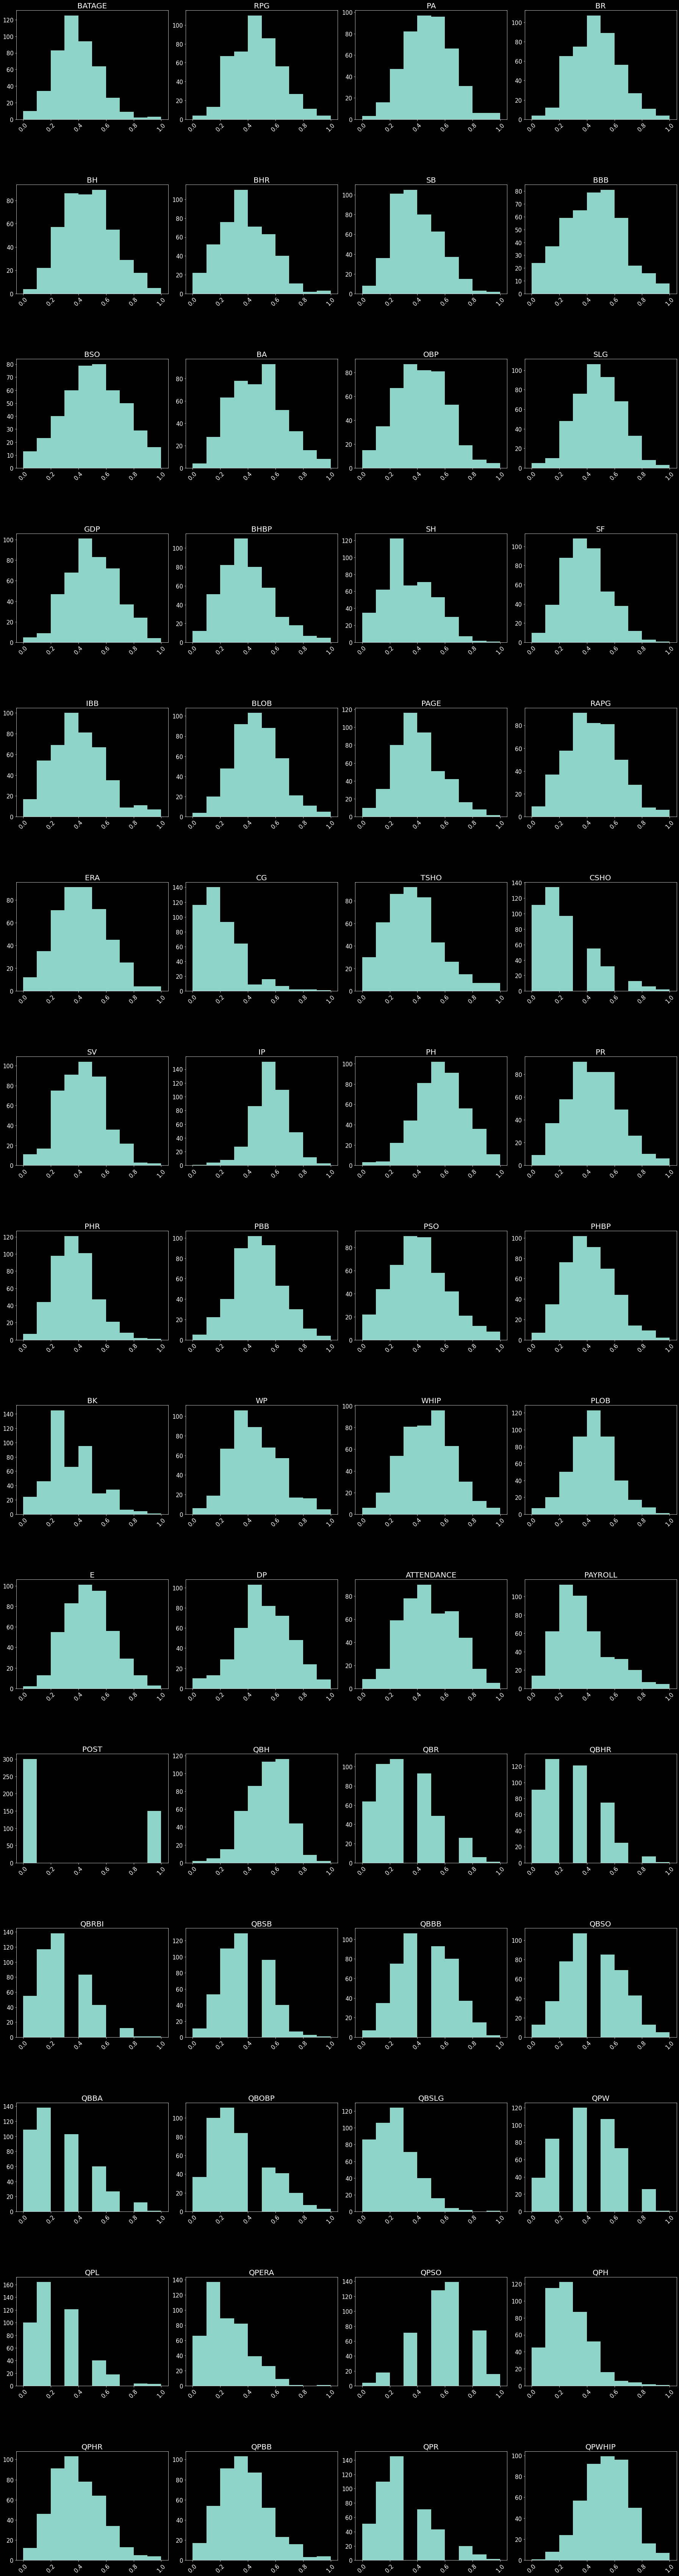

In [24]:
#Ejecutar celda 2 veces en caso de que no arroje títulos

fig = plt.figure(figsize=(25,100)) 

for col,num in zip(new_df2.toPandas().describe().columns, range(1,61)):
    ax = fig.add_subplot(16,4,num)
    ax.hist(new_df2.toPandas()[col])
    plt.style.use('dark_background') 
    plt.grid(False)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(col.upper(),fontsize=20)
plt.tight_layout()
fig.subplots_adjust(top=1,hspace = 0.6)
plt.show()

# Base de datos Postgres

## Almacenamiento en DB

Mediante la función write se escribe el dataframe ya preprocesado en una base de datos de postgres que está corriendo en un contenedor de Docker. El nombre de la tabla es df_procesado y la contraseña para acceder la base de datos: testPassword.

In [18]:
new_df2 \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_procesado") \
    .save()

## Lectura del set desde la DB

Se lee el mismo dataset que recién hemos escrito en la DB de postgres. Ahora este dataframe se llamará **df_ml**.

In [19]:
df_ml = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "df_procesado") \
    .load()
df_ml.show(5)

+----------+----------+----------+----------+----------+---------+----------+---------+---------+--------+----------+-------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----+----------+----------+----------+----------+-----+-----+-----+----------+-----+----------+----------+----------+----------+---------+----------+----+----+----------+------+-----+
|    BatAge|       RpG|        PA|        bR|        bH|      bHR|        SB|      bBB|      bSO|      BA|       OBP|    SLG|       GDP|       bHBP|        SH|        SF|       IBB|      bLOB|      PAge|      RApG|       ERA|         CG|      tSho|      cSho|        SV|        IP|        pH|        pR|       pHR|       pBB|       pSO|      pHBP|        BK|        WP|      WHIP| 

Se vuelve a presentar el summary de valores estadísticos del dataframe, pero ahora tomando en cuenta que se trata del set normalizado.

In [20]:
df_ml_summary=df_ml.summary()
summary_res_ml=TransposeDF(df_ml_summary, df_ml.columns, "summary").sort("summary")
summary_res_ml.show(summary_res_ml.count())

+----------+-----------+----------+----------+-----+---+-------------------+---+-------------------+
|   summary|        25%|       50%|       75%|count|max|               mean|min|             stddev|
+----------+-----------+----------+----------+-----+---+-------------------+---+-------------------+
|Attendance|  0.3343461| 0.4630767|0.63278115|  450|1.0|0.48051936784966126|0.0|0.19424634774193447|
|        BA|   0.328125|   0.46875|   0.59375|  450|1.0|0.47149305555555554|0.0|0.19302302489780448|
|        BK|        0.2|0.33333334|0.46666667|  450|1.0| 0.3333333431680997|0.0| 0.1693693305088228|
|    BatAge|  0.2962963|0.38271606| 0.4814815|  450|1.0| 0.3915500669678052|0.0|0.15214706964482536|
|        CG|0.055555556|0.16666667| 0.2777778|  450|1.0|0.20185185607108805|0.0|0.15940417298336662|
|        DP| 0.40206185| 0.5154639|0.63917524|  450|1.0| 0.5185795975497199|0.0| 0.1899485106051097|
|         E| 0.35955057|0.48314607| 0.5955056|  450|1.0| 0.4776779019667043|0.0|0.169700975

## Creación del Vector Assembler para el Modelo
Se vuelve a utilizar la función VectorAssembler para preparar una vector que contenga todos los features que se utlizarán para el modelo de ML.

In [21]:
df_clean_ml=df_ml.drop("Post")
assembler = VectorAssembler(
    inputCols=df_clean_ml.columns,
    outputCol='features')

vector_df = assembler.transform(df_ml)
vector_df.show(5,truncate=False)

+----------+----------+----------+----------+----------+---------+----------+---------+---------+--------+----------+-------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----+----------+----------+----------+----------+-----+-----+-----+----------+-----+----------+----------+----------+----------+---------+----------+----+----+----------+------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Gráfica de Correlaciones

Previo a generar los modelos de ML, se imprime una gráfica de correlaciones para comprender qué atributos van a tener más relación entre sí a la hora de predecir si un equipo clasificará o no a Postemporada. 

Se muestran en su mayoría muchos atributos que no tienen relación entre sí, cuyo aporte al modelo se puede analizar como independiente y que no va a generar conflictos a la hora de generar el entrenamiento del modelo.

In [159]:
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')
sns.set(rc={"figure.figsize":(200,200)})

# Creación de los Modelos de Clasificación

Primeramente del set de datos se toma una muestra del 70% para datos de training y 30% para probar el modelo con el test.

Se imprime la cantidad de instancias que serán utilizadas para cada una de las fases, así como el conteo de etiquetas (0-1) por subconjunto de datos. Se obtiene una relación similar entre los datos de testing y training en cuanto a desbalance de etiquetas.

In [22]:
vector_df = vector_df.withColumnRenamed('Post', 'label')
splits = vector_df.randomSplit([0.7, 0.3], 4321)
train = splits[0]
test = splits[1]

print("Cantidad de instancias Training: "+str(train.count()))
print("Cantidad de instancias Test: "+str(test.count()))
print("Conteo etiquetas set de training:")
train.groupby("label").count().show()
print("Conteo etiquetas set de test:")
test.groupby("label").count().show()

Cantidad de instancias Training: 317
Cantidad de instancias Test: 133
Conteo etiquetas set de training:
+-----+-----+
|label|count|
+-----+-----+
|  1.0|  109|
|  0.0|  208|
+-----+-----+

Conteo etiquetas set de test:
+-----+-----+
|label|count|
+-----+-----+
|  1.0|   41|
|  0.0|   92|
+-----+-----+



## Selección de métrica de Clasificación Binaria

Según Machine Learning Mastery (imagen inferior), es recomendable para casos de datasets desbalanceados, de clasificación binaria y donde la clase positiva tiene un mayor impacto, utilizar las métricas F-Score. 

Ahora bien se determina que para este problema será más perjudicial obtener falsos positivos, es decir, concluir que un equipo va a clasificar a Postemporada y que en la vida real esto no suceda.

Por lo tanto, siguiendo el diagrama mostrado, se elige a la métrica F0.5-Score como criterio de comparación de la calidad del modelo generado. Esta métrica se calcula de la siguiente forma:

$$F0. 5-Score = ((1 + 0.5^2) * Precision * Recall) / (0.5^2 * Precision + Recall)$$

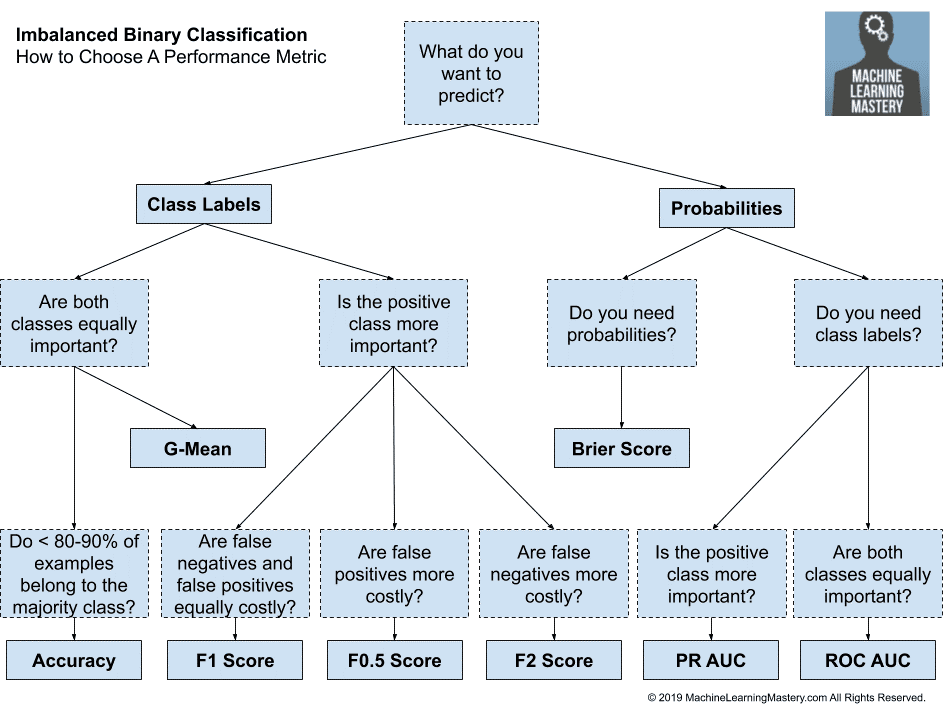

## Modelo 1: Multilayer Perceptron Binary Classifier

Como primer modelo de clasificación, se elige emplear el perceptrón multicapa. Esto debido a que se está trabajando un modelo no lineal y que por lo tanto una red neuronal puede desenvolverse bien en estos casos.

De la librería de PySpark, se importa la función MultilayerPerceptronClassifier. Además de la capa de entrada que posee el tamaño de la cantidad de atributos del set, se utilizarán 2 capas densas intermedias con 100 neuronas cada una y una capa de salida que al tratarse de clasificación binaria contará con 2 perceptrones. Como parámetros relevantes se elige un máximo de iteraciones de 300, y un tamaño de muestra o blockSize de 32.

Adicionalmente se utiliza la función de CrossValidator con 4 folds, esto para incrementar la variabilidad de los datos al entrenar el modelo y para tener mayor representatividad de ellos mismos.

Primero se construye la red y se entrena mediante validación cruzada.

In [78]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


layers = [len(assembler.getInputCols()), 100, 100, 2]

classifier = MultilayerPerceptronClassifier(labelCol='label',
                                            featuresCol='features',
                                            maxIter=300,
                                            layers=layers,
                                            blockSize=32,
                                            seed=2022)

grid = ParamGridBuilder() \
    .addGrid(classifier.maxIter,[300]) \
    .addGrid(classifier.layers, [layers]) \
    .addGrid(classifier.blockSize,[32]) \
    .addGrid(classifier.seed, [2022]) \
    .build()

evaluator = MulticlassClassificationEvaluator()
crossval = CrossValidator(estimator=classifier, 
                          estimatorParamMaps=grid, 
                          evaluator=evaluator, 
                          parallelism=2,
                          numFolds=4)

cvModel = crossval.fit(train)

## Training
### Métricas

Una vez generado el modelo, se calculan las principales métricas de clasificación el evaluarlo con los mismos datos de Training. 

In [79]:
from pyspark.mllib.evaluation import MulticlassMetrics

result_train_m1 = cvModel.transform(train)
pred_lab_tr_m1 = result_train_m1.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_tr_m1.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Train set accuracy = " + str(acc))
print("Train set precision = " + str(precision))
print("Train set recall = " + str(recall))
print("Train set f1-score = " + str(f1))
print("Train set f0.5-score = " + str(f05))

Train set accuracy = 1.0
Train set precision = 1.0
Train set recall = 1.0
Train set f1-score = 1.0
Train set f0.5-score = 1.0


### Matriz de confusión

De todas las métricas se obtiene un 100%, esto habla de que la red, realmente aprendió y ajustó los pesos de las neuronas para trabajar de buena forma con las instancias con las que se entrenó. La matriz de confusión a continuación lo demuestra:

In [25]:
print(metrics.confusionMatrix().toArray())

[[208.   0.]
 [  0. 109.]]


## Test
### Métricas
Ahora se evalúa realmente el modelo con los datos de Test. Se aplican las mismas métricas anteriores.

In [156]:
result_test_m1 = cvModel.transform(test)
pred_lab_te_m1 = result_test_m1.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_te_m1.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Test set accuracy = " + str(acc))
print("Test set precision = " + str(precision))
print("Test set recall = " + str(recall))
print("Test set f1-score = " + str(f1))
print("Test set f0.5-score = " + str(f05))

Test set accuracy = 0.8872180451127819
Test set precision = 0.8611111111111112
Test set recall = 0.7560975609756098
Test set f1-score = 0.8051948051948052
Test set f0.5-score = 0.8378378378378377


### Matriz de confusión
Al ser la métrica F0.5-Score la de mayor importancia para evaluar los distintos modelos, se toma este valor de 83.8% como referencia de lo que se ha obtenido con el perceptrón multicapa construido.

La matriz de confusión muestra cómo se obtuvo 87 etiquetas de no-clasificación correctas. Acertó 29 equipos que sí clasificaron a Postemporada y tuvo 15 errores entre Falsos Positivos y Falsos Negativos.

In [157]:
print(metrics.confusionMatrix().toArray())

[[87.  5.]
 [10. 31.]]


## Creación Dataframe resultados Modelo 1

Se crea un dataframe de PySpark con todas las columnas que utilizó el modelo durante el test, y particularmente con la columna de predicción de la etiqueta, así como la etiqueta real.

In [82]:
df_modelo1 = result_test_m1
# df_modelo1.show(5)

In [83]:
df_modelo1_view = df_modelo1.select("features","probability","prediction","label")
df_modelo1_view.printSchema()

root
 |-- features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- label: float (nullable = true)



Este dataframe permite visualizar más fácilmente la interacción entre predicciones y etiquetas reales.

In [84]:
df_modelo1_view.show()

+--------------------+--------------------+----------+-----+
|            features|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.02469135820865...|[1.0,1.4101075944...|       0.0|  0.0|
|[0.06172839552164...|[1.0,4.1170148448...|       0.0|  0.0|
|[0.08641975373029...|[1.0,3.2548828532...|       0.0|  0.0|
|[0.13580246269702...|[1.0,3.1174151417...|       0.0|  0.0|
|[0.14814814925193...|[1.0,8.7640053466...|       0.0|  0.0|
|[0.16049382090568...|[1.0,3.0204551512...|       0.0|  0.0|
|[0.16049382090568...|[1.0,5.4107285005...|       0.0|  0.0|
|[0.17283950746059...|[1.0,1.7900083124...|       0.0|  0.0|
|[0.17283950746059...|[1.0,2.5525393297...|       0.0|  0.0|
|[0.18518517911434...|[1.0,3.0714342348...|       0.0|  0.0|
|[0.18518517911434...|[6.40330832231957...|       1.0|  1.0|
|[0.19753086566925...|[1.0,6.8011988028...|       0.0|  0.0|
|[0.19753086566925...|[0.99999999293314...|       0.0|  0.0|
|[0.19753086566925...|[8

Se remueven las columnas de features y probability del dataframe que finalmente se enviará a la DB.

In [85]:
df_modelo1_db = df_modelo1.drop("features", "rawPrediction", "probability")
# df_modelo1_db.show()

## Interacción con Postgres

Mismo objetivo de la escritura anterior de la base de datos, misma contraseña, sólo que cambia el nombre del set ahora se llamará modelo1_proyecto para consultarlo a través de Postgres. 

Escritura en DB:

In [86]:
df_modelo1_db \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_proyecto") \
    .save()

Lectura e impresión del dataframe trayéndolo desde postgres.

In [87]:
df_modelo1_read = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo1_proyecto") \
    .load()
df_modelo1_read.show(5)

+-----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+----------+-------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----+---------+----------+----------+----------+-----+-----+-----+----------+-----+----------+----------+----------+----------+----------+----------+----+----+----------+------+-----+----------+
|     BatAge|       RpG|        PA|        bR|        bH|       bHR|        SB|       bBB|       bSO|      BA|       OBP|    SLG|       GDP|      bHBP|        SH|        SF|       IBB|      bLOB|       PAge|      RApG|       ERA|        CG|      tSho|      cSho|        SV|        IP|       pH|        pR|       pHR|       pBB|       pSO|      pHBP|        BK|       

# Modelo 2: Random Forest Classifier

Como segundo modelo de clasificación, se elige emplear Random Forest. Al ser un método bootstrapping permite consultar múltiples árboles de decisión generados de manera aleatoria y analizarlo bajo features aleatorios también. Para finalmente contemplar la respuesta que cada uno de los árboles tuvo. Dada la cantidad de atributos que se tienen en el modelo, se plantea evaluar este método.

Para esto se utiliza la función RandomForestClassifier. En este caso, solamente es necesario definir el número de árboles a construir que serán 250 y la profundidad de cada uno de estos que se tratará de 5 nodos u hojas. Como parámetro de muestreo de los features se elige "sqrt", que calcula la raíz cuadrada del total de features para determinar la cantidad de features que se utilizarán por árbol.

También se vuelve a utilizar la función de CrossValidator con 4 folds, con el mismo objetivo del modelo anterior.


In [124]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier

clf_rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', numTrees=250, maxDepth=5,featureSubsetStrategy="sqrt")

grid = (ParamGridBuilder()
             .addGrid(clf_rf.numTrees,[250])
             .addGrid(clf_rf.maxDepth,[5])
             .addGrid(clf_rf.featureSubsetStrategy,["sqrt"])
             .build())

rfEval = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=clf_rf, 
                    estimatorParamMaps=grid, 
                    evaluator=rfEval,
                    parallelism=2,
                    numFolds=4)

rfModel = cv.fit(train)

22/07/07 15:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB
22/07/07 15:42:05 WARN DAGScheduler: Broadcasting large task binary with size 1229.0 KiB
22/07/07 15:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
22/07/07 15:42:11 WARN DAGScheduler: Broadcasting large task binary with size 1230.4 KiB


## Training
### Métricas

De igual forma, calculo las principales métricas de clasificación el evaluar el modelo con los datos de Training. 

In [128]:
result_train_m2 = rfModel.transform(train)
pred_lab_tr_m2 = result_train_m2.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_tr_m2.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Train set accuracy = " + str(acc))
print("Train set precision = " + str(precision))
print("Train set recall = " + str(recall))
print("Train set f1-score = " + str(f1))
print("Train set f0.5-score = " + str(f05))

22/07/07 15:42:40 WARN DAGScheduler: Broadcasting large task binary with size 1270.8 KiB
22/07/07 15:42:40 WARN DAGScheduler: Broadcasting large task binary with size 1282.0 KiB
Train set accuracy = 0.9842271293375394
Train set precision = 0.9905660377358491
Train set recall = 0.963302752293578
Train set f1-score = 0.9767441860465116
Train set f0.5-score = 0.9849906191369605


### Matriz de confusión

En este caso no se obtiene un 100% unánime de las métricas como en el caso anterior, sino que resultan un tanto inferior. Específicamente, en cuanto a F0.5-Score se obtiene un 98.5%. De igual manera, sigue siendo un valor alto que comprueba un buen aprendizaje con respecto a los datos de training. La matriz de confusión es la siguiente:

In [129]:
print(metrics.confusionMatrix().toArray())

[[207.   1.]
 [  4. 105.]]


## Test
### Métricas
Se evalúa el modelo con los datos de Test. Se reiteran las mismas métricas.

In [126]:
result_test_m2 = rfModel.transform(test)
pred_lab_te_m2 = result_test_m2.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_te_m2.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Test set accuracy = " + str(acc))
print("Test set precision = " + str(precision))
print("Test set recall = " + str(recall))
print("Test set f1-score = " + str(f1))
print("Test set f0.5-score = " + str(f05))

22/07/07 15:42:21 WARN DAGScheduler: Broadcasting large task binary with size 1270.8 KiB
22/07/07 15:42:22 WARN DAGScheduler: Broadcasting large task binary with size 1282.0 KiB
Test set accuracy = 0.9172932330827067
Test set precision = 0.8947368421052632
Test set recall = 0.8292682926829268
Test set f1-score = 0.860759493670886
Test set f0.5-score = 0.8808290155440415


### Matriz de confusión
En cuanto a F0.5-Score, se obtiene un valor de 88.1%. Aunque accuracy no se esté considerando para el análisis, es importante resaltar que supera inclusive el 90%.

La matriz de confusión identifica 88 etiquetas de no-clasificación correctas. También como aciertos, 34 equipos que sí clasificaron a Postemporada y global tuvo 11 errores entre Falsos Positivos y Negativos.

In [127]:
print(metrics.confusionMatrix().toArray())

[[88.  4.]
 [ 7. 34.]]


## Creación Dataframe resultados Modelo 2

Se crea un dataframe de PySpark con todas las columnas que utilizó el modelo durante el test, y particularmente con la columna de predicción de la etiqueta, así como la etiqueta real. Se sigue la misma secuencia de pasos que en el Modelo 1 hasta llegarlo a escribir a la DB de Postgresql.

In [130]:
df_modelo2 = result_test_m2
# df_modelo1.show(5)

In [131]:
df_modelo2_view = df_modelo2.select("features","probability","prediction","label")
df_modelo2_view.printSchema()

root
 |-- features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- label: float (nullable = true)



In [132]:
df_modelo2_view.show()

22/07/07 15:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1276.0 KiB
+--------------------+--------------------+----------+-----+
|            features|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.02469135820865...|[0.88000531104739...|       0.0|  0.0|
|[0.06172839552164...|[0.92267780643386...|       0.0|  0.0|
|[0.08641975373029...|[0.95731048596740...|       0.0|  0.0|
|[0.13580246269702...|[0.97350381012259...|       0.0|  0.0|
|[0.14814814925193...|[0.97958264942031...|       0.0|  0.0|
|[0.16049382090568...|[0.98271606499823...|       0.0|  0.0|
|[0.16049382090568...|[0.98389648241598...|       0.0|  0.0|
|[0.17283950746059...|[0.59009243786797...|       0.0|  0.0|
|[0.17283950746059...|[0.98033858427059...|       0.0|  0.0|
|[0.18518517911434...|[0.97496903852841...|       0.0|  0.0|
|[0.18518517911434...|[0.21759106523952...|       1.0|  1.0|
|[0.19753086566925...|[0.87273266184592...|       0.0|  0

In [133]:
df_modelo2_db = df_modelo2.drop("features", "rawPrediction", "probability")

## Interacción con Postgres

Mismo objetivo de la escritura anterior de la base de datos, misma contraseña. El nombre es modelo2_proyecto para consultarlo a través de Postgres. 

Escritura en DB:

In [134]:
df_modelo2_db \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2_proyecto") \
    .save()

22/07/07 15:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1284.0 KiB


Lectura e impresión del dataframe trayéndolo desde postgres.

In [135]:
df_modelo2_read = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo2_proyecto") \
    .load()
df_modelo2_read.show(5)

+-----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+----------+-------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----+---------+----------+----------+----------+-----+-----+-----+----------+-----+----------+----------+----------+----------+----------+----------+----+----+----------+------+-----+----------+
|     BatAge|       RpG|        PA|        bR|        bH|       bHR|        SB|       bBB|       bSO|      BA|       OBP|    SLG|       GDP|      bHBP|        SH|        SF|       IBB|      bLOB|       PAge|      RApG|       ERA|        CG|      tSho|      cSho|        SV|        IP|       pH|        pR|       pHR|       pBB|       pSO|      pHBP|        BK|       

# Modelo 3: Gradient Boosted Tree Classifier

Como tercero y último modelo de clasificación, y siguiendo en la línea de los métodos de boosting, se elige evaluar Gradient Boosted Trees. Al obtener resultados positivos con Random Forest, que a su vez está basado en Decision Trees, se considera de interés aplicar otro método relacionado, pero con una cualidad de Boosting para reducir biases. Además, este método también permite incluir el concepto de descenso de greadiente cómo técnica para reducir la pérdida.

Para esto se utiliza la función GBTClassifier. Es fundamental definir el número de iteraciones en el modelo, que será de 150, la profundidad en los nodos que será de 5 y la cantidad de cajones o bins donde se agruparán los datos por iteración. Aumentar estos parámetros incrementa significativamente el tiempo de resolución y no se aprecia que mejoren las métricas calculadas.

También se vuelve a utilizar la función de CrossValidator con 4 folds, con el mismo objetivo de los modelos anteriores.

In [160]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import GBTClassifier

clf_gbt = GBTClassifier(featuresCol = 'features', labelCol = 'label', maxIter=150, maxDepth=5, maxBins=10)

grid = (ParamGridBuilder()
             .addGrid(clf_gbt.maxIter,[150])
             .addGrid(clf_gbt.maxDepth,[5])
             .addGrid(clf_gbt.maxBins, [10])
             .build())

gbtEval = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=clf_gbt, 
                    estimatorParamMaps=grid, 
                    evaluator=gbtEval,
                    parallelism=2,
                    numFolds=4)

gbtModel = cv.fit(train)

22/07/07 20:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1001.4 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1003.7 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1004.2 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1004.8 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1005.9 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1008.1 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1010.4 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1010.9 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1011.4 KiB
22/07/07 20:10:33 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
22/07/07 20:10:34 WARN DAGScheduler: Broadcasting large task binary with size 1014.8 KiB
22/07/07 20:10:34 WAR

## Training
### Métricas

Se calculan las principales métricas de clasificación el evaluar el modelo con los datos de Training. 

In [161]:
result_train_m3 = gbtModel.transform(train)
pred_lab_tr_m3 = result_train_m3.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_tr_m3.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Train set accuracy = " + str(acc))
print("Train set precision = " + str(precision))
print("Train set recall = " + str(recall))
print("Train set f1-score = " + str(f1))
print("Train set f0.5-score = " + str(f05))

22/07/07 20:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB


22/07/07 20:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1108.9 KiB
Train set accuracy = 1.0
Train set precision = 1.0
Train set recall = 1.0
Train set f1-score = 1.0
Train set f0.5-score = 1.0


### Matriz de confusión

De todas las métricas se obtiene un 100%, esto habla de un modelo que se ha ajustado muy bien a los datos de training. La matriz de confusión a continuación lo demuestra:

In [162]:
print(metrics.confusionMatrix().toArray())

[[208.   0.]
 [  0. 109.]]


## Test
### Métricas
Ahora se evalúa el modelo con los datos de Test. Se aplican las mismas métricas.

In [163]:
result_test_m3 = gbtModel.transform(test)
pred_lab_te_m3 = result_test_m3.select("prediction", "label")

metrics = MulticlassMetrics(pred_lab_te_m3.rdd.map(tuple))

acc = metrics.accuracy
f1 = metrics.fMeasure(1.0)
precision = metrics.precision(1.0)
recall = metrics.recall(1.0)
f05 = ((1+0.5**2)*precision*recall)/((0.5**2)*precision+recall)

print("Test set accuracy = " + str(acc))
print("Test set precision = " + str(precision))
print("Test set recall = " + str(recall))
print("Test set f1-score = " + str(f1))
print("Test set f0.5-score = " + str(f05))

22/07/07 20:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB
22/07/07 20:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1108.9 KiB
Test set accuracy = 0.8796992481203008
Test set precision = 0.8205128205128205
Test set recall = 0.7804878048780488
Test set f1-score = 0.8
Test set f0.5-score = 0.8121827411167513


### Matriz de confusión
Con respecto a F0.5-Score, se obtiene un valor de 81.2%, el cual guarda relación con los porcentajes que se obtuvieron de los modelos anteriores.

La matriz de confusión muestra que el modelo arrojó 85 etiquetas de no-clasificación correctas. Tuvo 32 aciertos de equipos que sí clasificaron a Postemporada y concluyó 16 errores entre Falsos Positivos y Falsos Negativos.

In [164]:
print(metrics.confusionMatrix().toArray())

[[85.  7.]
 [ 9. 32.]]


## Creación Dataframe resultados Modelo 3

De igual forma se crea un dataframe de PySpark con todas las columnas que utilizó el modelo durante el test, y se siguen los mismos pasos de los modelos anteriores para llevar la tabla con los resultados del modelo a la DB de Postgresql.

In [50]:
df_modelo3 = result_test_m3
# df_modelo1.show(5)

In [51]:
df_modelo3_view = df_modelo3.select("features","probability","prediction","label")
df_modelo3_view.printSchema()

root
 |-- features: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- label: float (nullable = true)



In [52]:
df_modelo3_view.show()

+--------------------+--------------------+----------+-----+
|            features|         probability|prediction|label|
+--------------------+--------------------+----------+-----+
|[0.02469135820865...|[0.42442425348494...|       1.0|  0.0|
|[0.06172839552164...|[0.96786154439872...|       0.0|  0.0|
|[0.08641975373029...|[0.96865294031210...|       0.0|  0.0|
|[0.13580246269702...|[0.96865294031210...|       0.0|  0.0|
|[0.14814814925193...|[0.96865294031210...|       0.0|  0.0|
|[0.16049382090568...|[0.96865294031210...|       0.0|  0.0|
|[0.16049382090568...|[0.96865294031210...|       0.0|  0.0|
|[0.17283950746059...|[0.23585719732305...|       1.0|  0.0|
|[0.17283950746059...|[0.96865294031210...|       0.0|  0.0|
|[0.18518517911434...|[0.96865294031210...|       0.0|  0.0|
|[0.18518517911434...|[0.08371674877203...|       1.0|  1.0|
|[0.19753086566925...|[0.96554534930328...|       0.0|  0.0|
|[0.19753086566925...|[0.88281741569130...|       0.0|  0.0|
|[0.19753086566925...|[0

In [53]:
df_modelo3_db = df_modelo3.drop("features", "rawPrediction", "probability")

## Interacción con Postgres

Mismo objetivo de la escritura anterior de la base de datos, misma contraseña, sólo que cambia el nombre del set ahora se llamará modelo1 para consultarlo a través de Postgres. 

Escritura en DB:

In [54]:
df_modelo3_db \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo3_proyecto") \
    .save()

Lectura e impresión del dataframe trayéndolo desde postgres.

In [55]:
df_modelo3_read = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "modelo3_proyecto") \
    .load()
df_modelo3_read.show(5)

+-----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+----------+-------+----------+----------+----------+----------+----------+----------+-----------+----------+----------+----------+----------+----------+----------+----------+---------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----+---------+----------+----------+----------+-----+-----+-----+----------+-----+----------+----------+----------+----------+----------+----------+----+----+----------+------+-----+----------+
|     BatAge|       RpG|        PA|        bR|        bH|       bHR|        SB|       bBB|       bSO|      BA|       OBP|    SLG|       GDP|      bHBP|        SH|        SF|       IBB|      bLOB|       PAge|      RApG|       ERA|        CG|      tSho|      cSho|        SV|        IP|       pH|        pR|       pHR|       pBB|       pSO|      pHBP|        BK|       

# Análisis de resultados

Para analizar mejor los resultados obtenidos de los 3 modelos desarrollados se genera esta tabla resume, que agrupa las principales métricas empleadas:

|                         | Modelo 1: Multilayer Perceptron | Modelo 2: Random Forest | Modelo 3: Gradiente Boosted Trees |
|:-----------------------:|:-------------------------------:|:-----------------------:|:---------------------------------:|
|      Train Accuracy     |               100%              |          98.4%          |                100%               |
|      Test  Accuracy     |              88.7%              |          91.7%          |               87.9%               |
|    Train F0.5- Score    |               100%              |          98.5%          |                100%               |
|     Test F0.5- Score    |              83.8%              |          88.1%          |               81.2%               |
| Differential F0.5-Score |              16.2%              |          10.4%          |               18.8%               |
|   Test True Positives   |                31               |            34           |                 32                |
|   Test False Positives  |                5                |            4            |                 7                 |
|   Test True Negatives   |                87               |            88           |                 85                |
|   Test False Negatives  |                10               |            7            |                 9                 |

De esta tabla resumen, se observa cómo en cuanto a conteo de equipos correctamente clasificados como "clasificados a Postemporada" o no, los 3 modelos arrojan valores varían muy poco entre sí. No obstante, dado que se analizó al inicio que los Falsos Postivos son los errores que más podrían afectar, entonces se debería concluir que el Modelo 2 fue el que mejor lo hizo.

Por otra parte al analizar F0.5 Score, tanto para training como para testing por modelo, sí se concluye una diferencia significativa entre cada uno de los modelos. Es decir, con el modelo 1 se obtuvo un diferencial con respecto a esta métrica de 16.2% entre los datos de training y los de test. Para el modelo 2, este diferencial fue de 10.4% y con el modelo 3, el mayor de todos, un 18.8%. Esto quiere decir, que en general existe overfitting por parte de los 3 modelos. Esto ocurre cuando en training, el desempeño se acerca a la perfección, pero en test no ocurre lo mismo. Ahora bien, de los 3 modelos, el que obtuvo un diferencial menor fue el segundo, mucho menor al compararse con los otros 2 modelos.

Por estos motivos, además de que representó un tiempo menor en la ejecución del algoritmo, se elige a Random Forest como modelo recomendado para darle solución a este problema de clasificación binaria.

# Siguientes pasos:

* Estudiar que otros atributos de las bases de datos consultadas, se pueden incluir en el análisis y que enriquezcan los modelos de predicción.

* Completar el estudio con más instancias, es decir incluir más equipos de años anterior. Por ejemplo del 2000 al 2006. Analizar si inclusive años anteriores a estos, tienen concoordancia con el modelo a desarrollar, o podría introducir valores muy alejados del presente.

* Analizar el impacto que podría tener incluir técnicas de oversampling, con tal de aumentar la cantidad de muestras.

* Considerar la posibilidad de aplicar una técnica de reducción de dimensionalidad o selección de features con mayor relevancia para la etiqueta de clasificación. Esto con el objetivo de disminuir los atributos a procesar, hacer más ligera la ejecución y no alimentar con ruido al modelo. Además de tener mayor claridad de cuáles métricas describen mejor las probabilidades de que un equipo llegue a Postemporada.

* Evaluar otros métodos de ensamble de clasificación binaria.



# Referencias

https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

https://nikhil-suthar-bigdata.medium.com/how-to-transpose-spark-dataframe-fa82c079a6b

https://www.kaggle.com/code/usmantahirkiani/binary-classification-with-pyspark-and-mllib/notebook

https://www.baseball-reference.com/